In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns',None)

In [2]:
events = pd.read_csv("data/events.csv")
events.head()

,event_id,user_id,product_id,event_type,event_timestamp
0,E00000001,U009798,P001393,cart,2025-07-08T14:28:55.893919
1,E00000002,U005881,P000669,view,2025-10-19T23:00:44.067982
2,E00000003,U006348,P001404,view,2025-05-09T07:02:42.256662
3,E00000004,U002664,P000400,cart,2025-07-19T22:47:07.019634
4,E00000005,U005776,P000392,view,2024-10-24T10:20:33.602165


In [3]:
events.info()
events['event_type'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   event_id         80000 non-null  object
 1   user_id          80000 non-null  object
 2   product_id       80000 non-null  object
 3   event_type       80000 non-null  object
 4   event_timestamp  80000 non-null  object
dtypes: object(5)
memory usage: 3.1+ MB


event_type
view        56013
cart        12035
wishlist     7946
purchase     4006
Name: count, dtype: int64

In [4]:
events['event_timestamp'] = pd.to_datetime(events['event_timestamp'])

In [5]:
events.dtypes

event_id                   object
user_id                    object
product_id                 object
event_type                 object
event_timestamp    datetime64[ns]
dtype: object

In [6]:
events = events.drop_duplicates()
events = events.dropna(subset=['user_id','event_type','event_timestamp'])

In [7]:
events['event_type'].value_counts()

event_type
view        56013
cart        12035
wishlist     7946
purchase     4006
Name: count, dtype: int64

In [8]:
events = events[events['event_type'].isin(['view','cart','purchase'])]

In [9]:
events = events.sort_values(by=['user_id','event_timestamp'])
events.head()

,event_id,user_id,product_id,event_type,event_timestamp
72771,E00072772,U000001,P000265,cart,2024-01-13 13:42:05.607547
49521,E00049522,U000001,P001739,view,2025-04-05 09:34:26.206475
45585,E00045586,U000001,P001008,view,2025-04-13 23:22:47.182918
33006,E00033007,U000001,P001855,view,2025-08-20 17:38:34.526890
12113,E00012114,U000001,P001416,view,2025-09-22 09:02:17.315929


In [10]:
events.head()
events['event_type'].value_counts()

event_type
view        56013
cart        12035
purchase     4006
Name: count, dtype: int64

In [11]:
funnel = (
    events
    .groupby(['user_id','event_type'])
    .size()
    .unstack(fill_value=0)
)

funnel.head()

event_type,cart,purchase,view
user_id,,,
U000001,1,0,4
U000002,1,0,5
U000003,1,0,9
U000004,1,1,3
U000005,0,0,5


In [12]:
funnel['viewed'] = funnel.get('view',0)>0
funnel['added_to_cart'] = funnel.get('cart',0)>0
funnel['purchased'] = funnel.get('purchase',0)>0

funnel[['viewed','added_to_cart','purchased']].head()

event_type,viewed,added_to_cart,purchased
user_id,,,
U000001,True,True,False
U000002,True,True,False
U000003,True,True,False
U000004,True,True,True
U000005,True,False,False


In [13]:
total_users = funnel.shape[0]

view_users = funnel['viewed'].sum()
cart_users = funnel['added_to_cart'].sum()
purchase_users = funnel['purchased'].sum()

total_users,view_users,cart_users,purchase_users

(9992, np.int64(9961), np.int64(6994), np.int64(3281))

In [18]:
view_to_cart_rate = cart_users/view_users
cart_to_purchase_rate = purchase_users/cart_users
overall_conversion = purchase_users/view_users

view_to_cart_rate, cart_to_purchase_rate, overall_conversion

(np.float64(0.7021383395241442),
 np.float64(0.4691163854732628),
 np.float64(0.3293845999397651))

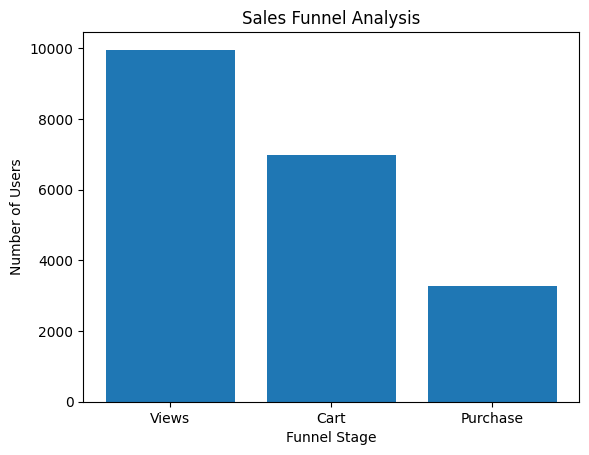

In [15]:
stages = ['Views','Cart','Purchase']
counts = [view_users, cart_users, purchase_users]

plt.figure()
plt.bar(stages,counts)
plt.title('Sales Funnel Analysis')
plt.xlabel('Funnel Stage')
plt.ylabel('Number of Users')
plt.show()

In [16]:
drop_view_to_cart = view_users-cart_users
drop_cart_to_purchase = cart_users-purchase_users

drop_view_to_cart, drop_cart_to_purchase

(np.int64(2967), np.int64(3713))

In [17]:
drop_rate_view_to_cart = drop_view_to_cart/view_users
drop_rate_cart_to_purchase = drop_cart_to_purchase / cart_users

drop_rate_view_to_cart, drop_rate_cart_to_purchase

(np.float64(0.2978616604758558), np.float64(0.5308836145267372))

In [20]:
funnel_summary = pd.DataFrame({
    'Stage' : ['View','Cart','Purchase'],
    'Users' : [view_users,cart_users,purchase_users],
    'Drop_off' : [0,drop_view_to_cart,drop_cart_to_purchase],
    'Conversion_Rate' : [1.0,view_to_cart_rate,cart_to_purchase_rate]
})

funnel_summary

,Stage,Users,Drop_off,Conversion_Rate
0,View,9961,0,1.000000
1,Cart,6994,2967,0.702138
2,Purchase,3281,3713,0.469116


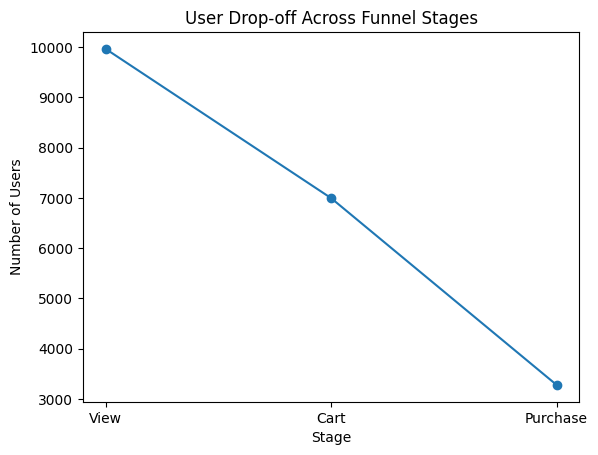

In [21]:
plt.figure()
plt.plot(funnel_summary['Stage'],funnel_summary['Users'],marker='o')
plt.title('User Drop-off Across Funnel Stages')
plt.xlabel('Stage')
plt.ylabel('Number of Users')
plt.show()